<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Machine_Learning/Tree_based/03-01-02-08-06-tree-based-models-bagging-grf-linear-model-forest-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 2.8.6 Linear Model Forest

A **Linear Model Forest** is a machine learning approach that combines the flexibility of random forests with the interpretability of linear models. It is designed to estimate `heterogeneous effects` or `conditional relationships` in data by fitting local linear models within the leaves of a random forest structure. While not a standard term in the `{grf}` package (which focuses on generalized random forests like `causal_forest` or `probability_forest`), the concept is closely related to methods like **Causal Forests with Linear Models** or **Local Linear Forest** extensions, where linear models are used to estimate effects or outcomes at the leaf level. Below, I’ll explain the concept, how it works, and its relevance, keeping it concise and clear.


## Overview

Linear Model Forest estimates conditional relationships (e.g., $E[Y|X]$ or treatment effects $E[Y(1) - Y(0)|X]$) by combining the non-parametric partitioning of random forests with linear models applied locally within subgroups (leaves).  Instead of averaging outcomes in each leaf (as in standard random forests), it fits a `linear model` in each leaf to capture relationships between covariates $X$, outcomes $Y$, or treatments $W$.



### Key Features

- `Heterogeneity`: Captures how relationships or effects vary across subgroups defined by $X$.

- `Interpretability`: Local linear models provide coefficients, making it easier to understand covariate effects within leaves compared to black-box random forests.

- `Flexibility`: Combines non-parametric partitioning (random forest) with parametric modeling (linear models).

- `Robustness`: Ensemble averaging reduces variance and overfitting.

- `Applications`: Ideal for causal inference (e.g., personalized medicine) or regression tasks where linear relationships hold locally but not globally.


### How It Work

A Linear Model Forest modifies the random forest framework as follows:

1. Data Setup

   - Input: Covariates $X$ (e.g., age, sex), outcome $Y$ (e.g., house price), and optionally a treatment  $W$ (covariates).
   - Data is typically a matrix of features $X$, a vector $Y$, and (if causal) a treatment indicator $W$.

2. Tree Construction

   - Like a random forest, it builds multiple decision trees (e.g., 1000) using bootstrap sampling and random feature selection.
   - Each tree partitions the covariate space $X$ into regions (leaves) based on splits that optimize a criterion (e.g., variance reduction or effect heterogeneity).

3. Local Linear Models

   - In each leaf, instead of computing a simple average (as in standard random forests), a `linear model` is fitted using the observations in that leaf.
   - For example:
   
     - `Regression`: $Y \sim \beta_0 + \beta_1 X_1 + \beta_2 X_2$ to predict $E[Y|X]$.
     
     - `Causal`: Estimate treatment effects $\tau(X) = E[Y(1) - Y(0)|X]$ using a linear model of $Y$ on $W$ and $X$.
  
   - The linear model leverages local data to capture linear relationships within the leaf’s subgroup.

4. Aggregation

   - For a given input $X$, each tree assigns $X$ to a leaf, and the local linear model in that leaf provides a prediction (e.g., outcome or treatment effect).
   
   - The forest averages predictions across all trees to produce a final estimate, ensuring robustness and reducing overfitting.

5. Output

   - C`onditional predictions` (e.g., $E[Y|X]$) or heterogeneous treatment effects (e.g., $\tau(X)$).
   
   - Optionally, `local linear coefficients` for interpretability (e.g., how covariates influence outcomes in specific subgroups).

### Differences from Other Forests

- `Vs. Standard Random Forest`: Uses simple averages in leaves, not linear models, and is less interpretable for local relationships.

- `Vs. Causal Forest`: Estimates treatment effects non-parametrically, while a Linear Model Forest uses linear models for effects within leaves, potentially improving precision if linear assumptions hold locally.

- `Vs. Probability Forest`: Focuses on class probabilities for categorical outcomes, not continuous outcomes or treatment effects with linear modeling.



### Limitations

- `Linear Assumption`: Assumes linear relationships within leaves, which may not hold for complex data.

- `Computational Cost`: Fitting linear models in each leaf is more intensive than standard random forest averaging.

- `Implementation`: Not natively supported in `{grf}`; requires custom extensions or alternative packages.

- `Data Requirements`: Needs sufficient data in each leaf to fit reliable linear models.

### Use Cases

  - Estimating heterogeneous treatment effects (e.g., how a drug’s effect varies by patient characteristics).
  - Modeling conditional means with linear relationships within subgroups.
  - Improving interpretability of random forest predictions with local linear coefficients.

## Setup R in Python Runtype

### Install {rpy2}

{rpy2} is a Python package that provides an interface to the R programming language, allowing Python users to run R code, call R functions, and manipulate R objects directly from Python. It enables seamless integration between Python and R, leveraging R's statistical and graphical capabilities while using Python's flexibility. The package supports passing data between the two languages and is widely used for statistical analysis, data visualization, and machine learning tasks that benefit from R's specialized libraries.

In [ ]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.5.1
Uninstalling rpy2-3.5.1:
  Successfully uninstalled rpy2-3.5.1
  Using cached rpy2-3.5.1-cp311-cp311-linux_x86_64.whl


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Linear Model Forest with R

This tutorial shows how to use  `lm_forest()` function of {grf} package to estimate the heterogeneous treatment effects (e.g., how house prices vary with different covariates) using a Linear Model Forest. We’ll cover data preparation, model fitting, prediction, and visualization of the estimated effects.



### Load and Check Required Libraries

In [ ]:
%%R
packages <- c('tidyverse',
              'plyr',
              'grf',
              'rdd',
              'survival',
              'mlbench',
              'Metrics'
         )

### Install Missing Packages

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

### Verify Installation

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:
tidyverse      plyr       grf       rdd  survival   mlbench   Metrics 
     TRUE      TRUE      TRUE      TRUE      TRUE      TRUE      TRUE 


### Load R Packages

In [ ]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))


### Check Loaded Packages

In [ ]:
%%R
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packageswer)

Successfully loaded packages:
 [1] "package:rdd"       "package:Formula"   "package:AER"      
 [4] "package:car"       "package:carData"   "package:lmtest"   
 [7] "package:zoo"       "package:sandwich"  "package:Metrics"  
[10] "package:mlbench"   "package:survival"  "package:grf"      
[13] "package:plyr"      "package:lubridate" "package:forcats"  
[16] "package:stringr"   "package:dplyr"     "package:purrr"    
[19] "package:readr"     "package:tidyr"     "package:tibble"   
[22] "package:ggplot2"   "package:tidyverse" "package:tools"    
[25] "package:stats"     "package:graphics"  "package:grDevices"
[28] "package:utils"     "package:datasets"  "package:methods"  
[31] "package:base"     


### Load Boston Housing Dataset

We use the Boston Housing dataset to demonstrate the implementation of a Regression Discontinuity Design (RDD) using the `{grf}` package. The dataset contains information about housing values in suburbs of Boston, including various features like crime rate, number of rooms, and more.


In [ ]:
%%R
# Load data
data(BostonHousing, package = "mlbench")
boston <- na.omit(BostonHousing)

### Prepare Data for RDD Analysis

RDD (Regression Discontinuity Design) is a quasi-experimental design used to estimate causal effects when treatment assignment is determined by a cutoff on a continuous variable. In this example, we will use the Boston Housing dataset to demonstrate how to implement RDD using the {grf} package in R.


In [ ]:
%%R
# Define variables for RDD
# Suppose we want to estimate the effect of high NOX (nitric oxides concentration) on house value (medv)
# We'll use a cutoff at the median NOX value for demonstration
Z <- boston$nox                      # Running variable
cutoff <- median(Z)                  # Cutoff for RDD
W <- as.numeric(Z >= cutoff)         # Treatment: 1 if NOX >= cutoff, else 0
Y <- boston$medv                     # Outcome: median value of owner-occupied homes
X <- model.matrix(~ . -medv -nox, data = boston)[, -1]  # All covariates except outcome & running variable

### Imbens-Kalyanaraman (IK) Optimal Bandwidth and Kernel Weights

To implement Regression discontinuity designs (RDD) using the `grf` package, we first need to compute the bandwidth for the running variable and then apply kernel weights to subset the data. First we will use `IKbandwith()` function of {rdd} to calculate the `Imbens-Kalyanaraman optimal bandwidth` for local linear regression in RDD.

In [ ]:
%%R
bandwidth <- IKbandwidth(Z, Y, cutoff)
bandwidth


[1] 0.06117268


Then we will calculate the kernel weights using the `kernelwts()` function from the `{rdd}` package. This function will calculate the appropriate kernel weights for a vector. This is useful when, for instance, one wishes to perform local regression.

In [ ]:
%%R
#  Compute triangular kernel weights
sample.weights <- kernelwts(Z, cutoff, bandwidth, "triangular")
# Subset to data within the bandwidth
subset <- sample.weights > 0


### Fit Local Linear Forest Targeting RDD Effect

We will use the `lm_forest()` function from the `{grf}` package to fit a local linear forest model that targets the RDD effect. The `gradient.weights` argument is set to `c(1, 0)` to indicate that we are interested in estimating the treatment effect (tau) at each point in the running variable.

In [ ]:
%%R
# Fit local linear forest targeting RDD effect (tau(x))
lmf <- lm_forest(
  X[subset, ],
  Y[subset],
  cbind(W, Z)[subset, ],
  sample.weights = sample.weights[subset],
  gradient.weights = c(1, 0)
)

print(lmf)

GRF forest object of type lm_forest 
Number of trees: 2000 
Number of training samples: 186 
Variable importance: 
    1     2     3     4     5     6     7     8     9    10    11    12 
0.135 0.017 0.208 0.002 0.132 0.057 0.115 0.042 0.085 0.077 0.043 0.085 


### Extract RDD Estimates (tau at each x)

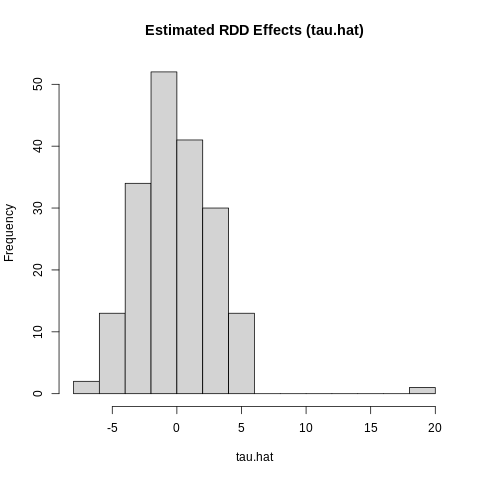

In [ ]:
%%R
# 5Extract RDD estimates (tau at each x)
tau.hat <- predict(lmf)$predictions[,1,]

# Display first few RDD treatment effect estimates
head(tau.hat)

# Osummary and diagnostics
summary(tau.hat)
hist(tau.hat, main="Estimated RDD Effects (tau.hat)", xlab="tau.hat")

### Prediction and Visualization

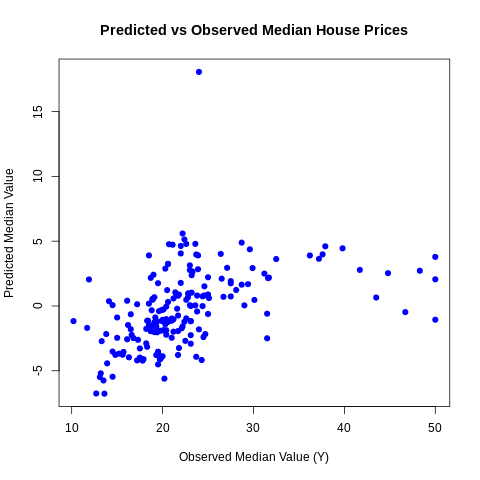

In [ ]:
%%R
Y_obs <- Y[subset]
Y_pred <- predict(lmf)$predictions[,1,]

plot(Y_obs, Y_pred,
     xlab = "Observed Median Value (Y)",
     ylab = "Predicted Median Value",
     main = "Predicted vs Observed Median House Prices",
     pch = 19, col = "blue")

### Variable Importance

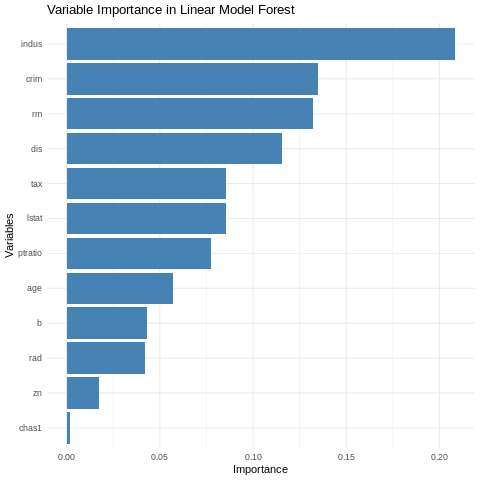

In [ ]:
%%R
# Calculate variable importance
importance <- variable_importance(lmf)
# Display variable importance
importance_df <- data.frame(
  Variable = colnames(X),
  Importance = importance
)
importance_df <- importance_df[order(-importance_df$Importance), ]
# Plot variable importance
ggplot(importance_df, aes(x = reorder(Variable, Importance), y = Importance)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  coord_flip() +
  labs(title = "Variable Importance in Linear Model Forest",
       x = "Variables",
       y = "Importance") +
  theme_minimal()

## Summary and Conclusion

The Linear Model Forest is a powerful tool for estimating heterogeneous effects or conditional relationships in data. By combining the flexibility of random forests with the interpretability of linear models, it allows for local linear modeling within subgroups defined by covariates. This approach is particularly useful in causal inference and regression tasks where understanding local relationships is crucial. This tutorial demonstrated how to implement a Linear Model Forest using the `lm_forest()` function from the `{grf}` package, focusing on predicting medium house price in a dataset. The steps included data preparation, model fitting, prediction, and visualization of results.
  

## References

1. Athey, Susan, Julie Tibshirani, and Stefan Wager. "Generalized Random Forests". Annals of Statistics, 47(2), 2019.

2. Zeileis, Achim, Torsten Hothorn, and Kurt Hornik. "Model-based Recursive Partitioning." Journal of Computational and Graphical Statistics 17(2), 2008.

3. [LM Forest](https://grf-labs.github.io/grf/reference/lm_forest.html#references)